# Horizontal Regridding

This notebook demonstrates regridding the ACCESS-OM2 output onto a different grid. In this example, regridding model output from all three ACCESS-OM2 resolutions on to a 1-degree longitude-latitude grid with regular spacing.

**Requirements:** The `conda/analysis3-24.04` module on ARE/gadi

**Firstly,** load in the requisite libraries:

In [1]:
import intake

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import xarray as xr

xr.set_options(keep_attrs=True)

import cf_xarray as cfxr

from dask.distributed import Client

import xesmf

Load a `dask` client. This is not required for small regridding jobs, and does not affect the speed of generating the regridding weights, but may improve speed, or reduce memory overhead, when regridding large datasets with, for example, large time dimensions.

In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34237,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:34151,Total threads: 1
Dashboard: /proxy/32791/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:36971,


Load a catalog; here we load the default ACCESS-NRI catalog.

In [3]:
catalog = intake.cat.access_nri

Next we load the grid parameters for each resolution. We use `.reset_coords()`, `.drop()` and `.rename()` on some grids to make them compatible with the `xesmf` package requirements.

In [4]:
grid1 = xr.open_dataset("/g/data/ik11/grids/ocean_grid_10.nc")
grid1 = grid1.reset_coords({"geolat_t", "geolon_t", "geolat_c", "geolon_c"})
grid1 = grid1.drop_vars({"xt_ocean", "yt_ocean", "xu_ocean", "yu_ocean"})

grid025 = xr.open_dataset("/g/data/ik11/grids/ocean_grid_025.nc")
grid025 = grid025.reset_coords({"geolat_t", "geolon_t", "geolat_c", "geolon_c"})
grid025 = grid025.drop_vars({"xt_ocean", "yt_ocean", "xu_ocean", "yu_ocean"})

grid010 = xr.open_dataset("/g/data/ik11/grids/ocean_grid_01.nc")
grid010 = grid010.rename(
    {
        "grid_x_C": "xu_ocean",
        "grid_y_C": "yu_ocean",
        "grid_x_T": "xt_ocean",
        "grid_y_T": "yt_ocean",
    }
)

## Load raw data

We load some raw data from ACCESS-OM2 models. In particular, we load here the 2 years of monthly sea-surface height from the inter-annually forced ocean model runs at three different resolutions. These experiments are part of the default database and are called:

- `1deg_jra55_iaf_omip2_cycle6` for ACCESS-OM2 1$^\circ$ degree,
- `025deg_jra55_iaf_omip2_cycle6` for ACCESS-OM2 0.25$^\circ$ degree,
- `01deg_jra55v140_iaf_cycle4` for ACCESS-OM2 0.1$^\circ$ degree.

We use the `intake` catalog to load our variables.

We make sure to assign the correct tripolar coordinates as `coords`. Since sea-surface height is lives on `t`-cells, we add `geolon_t` and `geolat_t`. We also rename them to `longitude` and `latitude` to ease our life further down (`xesmf` package that we will use for regridding automatically searches for coordinates named `longitude` and `latitude`.)

After we load the data we rechunk them according to how the regridder's needs; read further down for more details on this.

In [5]:
ds = (
    catalog["1deg_jra55_iaf_omip2_cycle6"]
    .search(variable="sea_level", frequency="1mon")
    .to_dask()
)

ssh_1 = (
    ds["sea_level"]
    .sel(time=slice("2000-01-01", "2001-12-31"))
    .cf.chunk({"time": "auto", "longitude": -1, "latitude": -1})
)
ssh_1 = ssh_1.assign_coords({"geolat_t": grid1.geolat_t, "geolon_t": grid1.geolon_t})
ssh_1 = ssh_1.rename(
    {"xt_ocean": "x", "yt_ocean": "y"}
)
ssh_1

<xarray.DataArray 'sea_level' (time: 24, y: 300, x: 360)> Size: 10MB
dask.array<rechunk-merge, shape=(24, 300, 360), dtype=float32, chunksize=(24, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * x         (x) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * y         (y) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * time      (time) datetime64[ns] 192B 2000-01-14T12:00:00 ... 2001-12-14T1...
    geolat_t  (y, x) float32 432kB ...
    geolon_t  (y, x) float32 432kB ...
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_height_above_geoid

In [6]:
ds = (
    catalog["025deg_jra55_iaf_omip2_cycle6"]
    .search(variable="sea_level", frequency="1mon")
    .to_dask()
)

ssh_025 = (
    ds["sea_level"]
    .sel(time=slice("2000-01-01", "2001-12-31"))
    .cf.chunk({"time": "auto", "longitude": -1, "latitude": -1})
)
ssh_025 = ssh_025.assign_coords(
    {"geolat_t": grid025.geolat_t, "geolon_t": grid025.geolon_t}
)
ssh_025 = ssh_025.rename(
    {"xt_ocean": "x", "yt_ocean": "y"}
)
ssh_025

<xarray.DataArray 'sea_level' (time: 24, y: 1080, x: 1440)> Size: 149MB
dask.array<rechunk-merge, shape=(24, 1080, 1440), dtype=float32, chunksize=(21, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * x         (x) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * y         (y) float64 9kB -81.08 -80.97 -80.87 -80.76 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 192B 2000-01-14T12:00:00 ... 2001-12-14T1...
    geolat_t  (y, x) float32 6MB ...
    geolon_t  (y, x) float32 6MB ...
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_height_above_geoid

In [7]:
ds = (
    catalog["01deg_jra55v140_iaf_cycle4"]
    .search(variable="sea_level", frequency="1mon")
    .to_dask()
)

ssh_010 = (
    ds["sea_level"]
    .sel(time=slice("2000-01-01", "2001-12-31"))
    .cf.chunk({"time": "auto", "longitude": -1, "latitude": -1})
)

ssh_010 = ssh_010.assign_coords(
    {"geolat_t": grid010.geolat_t, "geolon_t": grid010.geolon_t}
)
ssh_010 = ssh_010.rename(
    {"xt_ocean": "x", "yt_ocean": "y"}
)
ssh_010

<xarray.DataArray 'sea_level' (time: 24, y: 2700, x: 3600)> Size: 933MB
dask.array<rechunk-merge, shape=(24, 2700, 3600), dtype=float32, chunksize=(3, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * x         (x) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * y         (y) float64 22kB -81.11 -81.07 -81.02 -80.98 ... 89.89 89.94 89.98
  * time      (time) datetime64[ns] 192B 2000-01-16T12:00:00 ... 2001-12-16T1...
    geolat_t  (y, x) float64 78MB ...
    geolon_t  (y, x) float64 78MB ...
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_height_above_geoid

## Regrid using `xesmf`

We regrid all output onto a regular lat-lon grid with 1 degree lateral resolution. First we construct the `dataset` with the coordinates that we want to regrid onto.

In [8]:
ds_out = xesmf.util.grid_global(1, 1)

ds_out = ds_out.drop_vars({"lon_b", "lat_b"})

# we shift our longitude grid range from [-180, 180] to [-280, 80]
# this is only for visualisation purposes so that the grid's seam falls in
# the middle of the Indian Ocean rather than in the middle of the Pacific Ocean
ds_out = ds_out.assign_coords({"lon": ds_out.lon - 100.0})

ds_out = ds_out.rename({"lon": "longitude", "lat": "latitude"})
ds_out

<xarray.Dataset> Size: 1MB
Dimensions:    (y: 180, x: 360)
Coordinates:
    longitude  (y, x) float64 518kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
    latitude   (y, x) float64 518kB -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
Dimensions without coordinates: y, x
Data variables:
    *empty*

Let's have a look how the original ACCESS-OM2 1$^\circ$ grid (with the two poles in the Arctic region, north of 65$^\circ$N) compares with the "sane" latitude-longitude 1$^\circ$ grid.

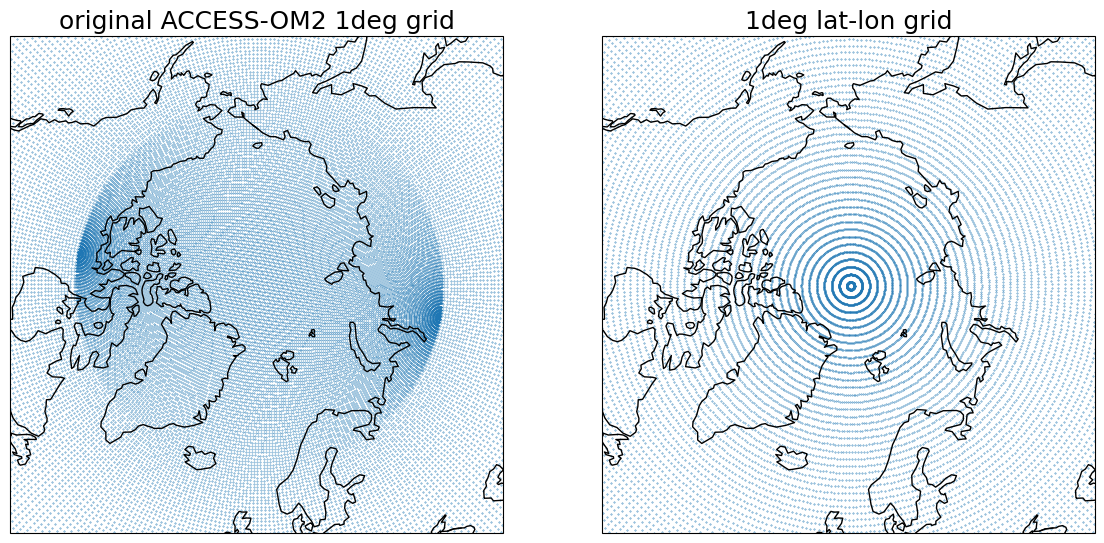

In [9]:
projection = ccrs.cartopy.crs.Orthographic(central_longitude=0.0, central_latitude=90)
fig, axes = plt.subplots(ncols=2, subplot_kw={"projection": projection}, figsize=(14, 8))

# plot grid locations
axes[0].scatter(ssh_1.geolon_t, ssh_1.geolat_t, s=0.1, transform=ccrs.PlateCarree())
axes[0].set_title("original ACCESS-OM2 1deg grid", fontsize=18)

# plot grid locations
axes[1].scatter(ds_out["longitude"], ds_out["latitude"], s=0.1, transform=ccrs.PlateCarree())
axes[1].set_title("1deg lat-lon grid", fontsize=18)

for ax in axes:
    ax.coastlines()
    ax.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())

To regrid our fields we need to construct the three regridders for the three different resolutions using `xesmf.Regridder()`. The `xesmf.Regridder()` function takes as input two datasets, one that includes the original grid and one that includes the grids we need to regrid on. (Type `?xesmf.Regridder` for the function's docstring.)

The names of the coordinates need to follow CF-convetions. 
We also make sure to drop the 1D coords `x` and `y` to **force** the regridder to use the 2D arrays `geolon_c` and `geolat_c`.

**Note**: The 0.10 degree `regridder_010degACCESSOM2_1deg` below should take ~3-4 minutes to compute.

In [10]:
%%time

regridder_1degACCESSOM2_1deg = xesmf.Regridder(
    ssh_1.drop_vars({"x", "y"}),
    ds_out,
    "bilinear",
    periodic=True,
    filename="bilinear_tracer_weights_in1degACCESSOM2_out1deg.nc",
)
regridder_1degACCESSOM2_1deg

[gadi-cpu-bdw-0299.gadi.nci.org.au:2948222] shmem: mmap: an error occurred while determining whether or not /jobfs/121130103.gadi-pbs/ompi.gadi-cpu-bdw-0299.12314/jf.0/4070244352/shared_mem_cuda_pool.gadi-cpu-bdw-0299 could be created.
[gadi-cpu-bdw-0299.gadi.nci.org.au:2948222] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


CPU times: user 9.48 s, sys: 1.02 s, total: 10.5 s
Wall time: 8.88 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_tracer_weights_in1degACCESSOM2_out1deg.nc 
Reuse pre-computed weights? False 
Input grid shape:           (300, 360) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [11]:
%%time

regridder_025degACCESSOM2_1deg = xesmf.Regridder(
    ssh_025.drop_vars({"x", "y"}),
    ds_out,
    "bilinear",
    periodic=True,
    filename="bilinear_tracer_weights_in025degACCESSOM2_out1deg.nc",
)
regridder_025degACCESSOM2_1deg

CPU times: user 1min, sys: 5.47 s, total: 1min 5s
Wall time: 50.4 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_tracer_weights_in025degACCESSOM2_out1deg.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1080, 1440) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [12]:
%%time

regridder_010degACCESSOM2_1deg = xesmf.Regridder(
    ssh_010.drop_vars({"x", "y"}),
    ds_out,
    "bilinear",
    periodic=True,
    filename="bilinear_tracer_weights_in010degACCESSOM2_out1deg.nc",
)
regridder_010degACCESSOM2_1deg

CPU times: user 4min 23s, sys: 21.9 s, total: 4min 45s
Wall time: 3min 41s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_tracer_weights_in010degACCESSOM2_out1deg.nc 
Reuse pre-computed weights? False 
Input grid shape:           (2700, 3600) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

#### Note

For large grids (e.g., to regrid from a 0.10$^\circ$ grid to a 0.20$^\circ$), it might take a while to compute the re-grid weights. But, once you compute the weights, you can construct a regridder using the already-computed weights from a netCDF file by providing with the `reuse_weights = True` argument, e.g.,

```python
regridder = xesmf.Regridder(dataset_in, dataset_out, 'bilinear', periodic=True, 
                            filename='weights_file.nc', reuse_weights=True)
```
or to automatically recalculate the weights file only in case it doesn't already exist, do
```python
import os

regridder = xesmf.Regridder(dataset_in, dataset_out, 'bilinear', periodic=True, 
                            filename='weights_file.nc',
                            reuse_weights=os.path.exists('weights_file.nc'))
```

## Let's regrid our output

Now we use the regridders we constructed above to regrid our output. Note that the dimensions we are applying the re-gridding can't be chunked, so when we opened the dataset, we set the chunks sizes to be the full size of x and y. The `time` axis can be chunked --- for big datasets make sure that you rechunk `time` if needed so you don't end up with *huge* chunk sizes. That is precisely why we used:

```python
.chunk({'time': 'auto', 'longitude': -1, 'latitude': -1})
```

to ensure this.

Note also that for the regridded data arrays, we add back the longitude/latitude values on coords `x`/`y` respectively to make our lives easier with plotting later on.

In [13]:
ssh_1_regridded = regridder_1degACCESSOM2_1deg(ssh_1)
ssh_1_regridded = ssh_1_regridded.drop_vars(["longitude", "latitude"])
ssh_1_regridded = ssh_1_regridded.assign_coords(
    {"x": ds_out.longitude.isel(y=0), "y": ds_out.latitude.isel(x=0)}
)
ssh_1_regridded = ssh_1_regridded.rename({"x": "longitude", "y": "latitude"})

ssh_1_regridded

<xarray.DataArray (time: 24, latitude: 180, longitude: 360)> Size: 6MB
dask.array<astype, shape=(24, 180, 360), dtype=float32, chunksize=(24, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 192B 2000-01-14T12:00:00 ... 2001-12-14T...
  * longitude  (longitude) float64 3kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    regrid_method:  bilinear

In [14]:
ssh_025_regridded = regridder_025degACCESSOM2_1deg(ssh_025)
ssh_025_regridded = ssh_025_regridded.drop_vars(["longitude", "latitude"])
ssh_025_regridded = ssh_025_regridded.assign_coords(
    {"x": ds_out.longitude.isel(y=0), "y": ds_out.latitude.isel(x=0)}
)
ssh_025_regridded = ssh_025_regridded.rename({"x": "longitude", "y": "latitude"})
ssh_025_regridded

<xarray.DataArray (time: 24, latitude: 180, longitude: 360)> Size: 6MB
dask.array<astype, shape=(24, 180, 360), dtype=float32, chunksize=(21, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 192B 2000-01-14T12:00:00 ... 2001-12-14T...
  * longitude  (longitude) float64 3kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    regrid_method:  bilinear

In [15]:
ssh_010_regridded = regridder_010degACCESSOM2_1deg(ssh_010)
ssh_010_regridded = ssh_010_regridded.drop_vars(["longitude", "latitude"])
ssh_010_regridded = ssh_010_regridded.assign_coords(
    {"x": ds_out.longitude.isel(y=0), "y": ds_out.latitude.isel(x=0)}
)
ssh_010_regridded = ssh_010_regridded.rename({"x": "longitude", "y": "latitude"})
ssh_010_regridded

<xarray.DataArray (time: 24, latitude: 180, longitude: 360)> Size: 6MB
dask.array<astype, shape=(24, 180, 360), dtype=float32, chunksize=(3, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 192B 2000-01-16T12:00:00 ... 2001-12-16T...
  * longitude  (longitude) float64 3kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    regrid_method:  bilinear

## Plotting time

Now we can plot the regridded fields, slicing as we like using `longitude` and `latitude` coordinates. Here's a comparisson of monthly-mean snapshots for sea-surface height in the North Pacific. Notice how things look "normal" north of 65$^\circ$N where the model's grid has the tripolar complications!

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 43.16 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 114.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 273.61 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


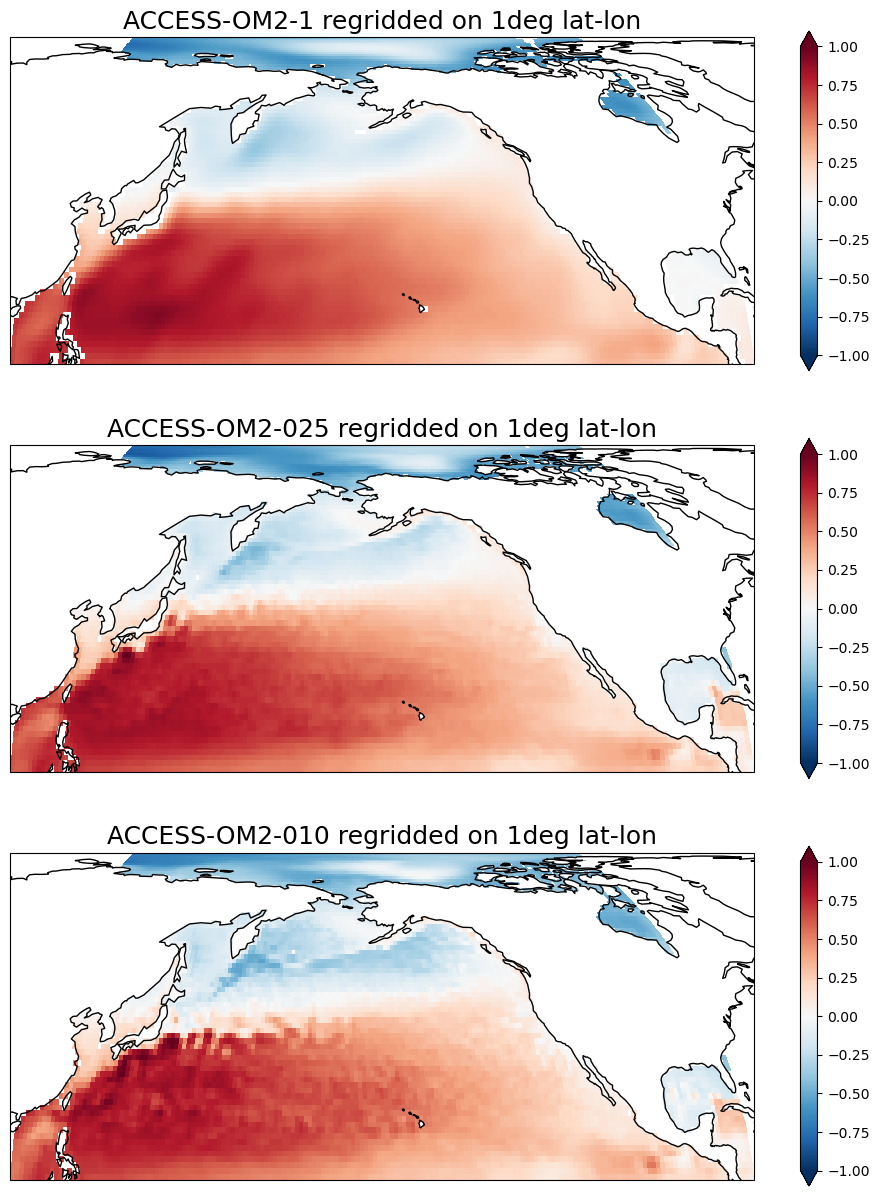

In [16]:
projection = ccrs.cartopy.crs.EqualEarth(central_longitude=180.0)

fig, axes = plt.subplots(
    nrows=3, subplot_kw={"projection": projection}, figsize=(12, 15)
)

for ax in axes:
    ax.coastlines()

ssh_1_regridded.isel(time=0).cf.sel(
    {"longitude": slice(-250, -80), "latitude": slice(10, 90)}
).plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    extend="both",
    vmin=-1,
    vmax=1,
    cmap="RdBu_r",
)
axes[0].set_title("ACCESS-OM2-1 regridded on 1deg lat-lon", fontsize=18)

ssh_025_regridded.isel(time=0).cf.sel(
    {"longitude": slice(-250, -80), "latitude": slice(10, 90)}
).plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    extend="both",
    vmin=-1,
    vmax=1,
    cmap="RdBu_r",
)

axes[1].set_title("ACCESS-OM2-025 regridded on 1deg lat-lon", fontsize=18)


ssh_010_regridded.isel(time=0).cf.sel(
    {"longitude": slice(-250, -80), "latitude": slice(10, 90)}
).plot(
    ax=axes[2],
    transform=ccrs.PlateCarree(),
    extend="both",
    vmin=-1,
    vmax=1,
    cmap="RdBu_r",
)

axes[2].set_title("ACCESS-OM2-010 regridded on 1deg lat-lon", fontsize=18);

Another thing we can do now that we have everything on the same grid is to compute difference between fields from different model resolutions.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 316.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


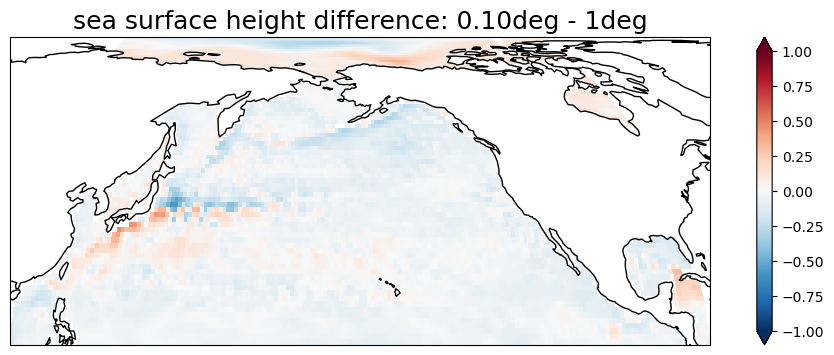

In [17]:
plt.figure(figsize=(12, 4))
ax = plt.axes(projection=ccrs.cartopy.crs.EqualEarth(central_longitude=180.0))

(ssh_010_regridded.isel(time=0) - ssh_1_regridded.isel(time=0)).cf.sel(
    {"longitude": slice(-250, -80), "latitude": slice(10, 90)}
).plot(
    ax=ax, transform=ccrs.PlateCarree(), extend="both", vmin=-1, vmax=1, cmap="RdBu_r"
)
ax.coastlines()
plt.title("sea surface height difference: 0.10deg - 1deg", fontsize=18);

## Further examples

The example that [compares sea ice observations with model outputs](https://cosima-recipes.readthedocs.io/en/latest/Examples/SeaIce_Obs_Model_Compare.html#Sea-Ice-Concentration-Anomalies) and also the "Regridders" section of the ["Ice maps analysis" notebook](https://nbviewer.jupyter.org/github/aekiss/ice_analysis/blob/main/ice_maps.ipynb#Regridders) include examples of functions that generate functions to regrid between ACCESS-OM2 resolutions and from various other datasets (JRA55, GIOMAS, and NSIDC) to the three ACCESS-OM2 resolutions. These regridder functions automatically save and reuse weights.

In [18]:
client.close()